Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-minyak-goreng-curah-malang-2017-2021.csv?token=ARB4LTCTM4YFVF6X5ZNMSMLAX3JLS \
    -O /tmp/oil.csv

--2021-06-01 02:25:22--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-minyak-goreng-curah-malang-2017-2021.csv?token=ARB4LTCTM4YFVF6X5ZNMSMLAX3JLS
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15792 (15K) [text/plain]
Saving to: ‘/tmp/oil.csv’

/tmp/oil.csv        100%[===================>]  15.42K  --.-KB/s    in 0s      

2021-06-01 02:25:22 (102 MB/s) - ‘/tmp/oil.csv’ saved [15792/15792]



In [3]:
#Read dataset with pandas, then put it to oil_df variable
oil_df = pd.read_csv('/tmp/oil.csv')
oil_df

tanggal  harga
0    2017-08-02  10350
1    2017-08-03  10350
2    2017-08-04  10350
3    2017-08-07  10350
4    2017-08-08  10350
..          ...    ...
935  2021-05-24  14150
936  2021-05-25  14150
937  2021-05-27  14150
938  2021-05-28  14150
939  2021-05-31  14150

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of oil_df dataframe
oil_df.head()

tanggal  harga
0  2017-08-02  10350
1  2017-08-03  10350
2  2017-08-04  10350
3  2017-08-07  10350
4  2017-08-08  10350

In [5]:
#Inspect the last 5 of oil_df dataframe
oil_df.tail()

tanggal  harga
935  2021-05-24  14150
936  2021-05-25  14150
937  2021-05-27  14150
938  2021-05-28  14150
939  2021-05-31  14150

In [6]:
#Inspect the describtion of oil_df dataframe
oil_df.describe()

harga
count    940.000000
mean   11152.180851
std     1334.636489
min     9350.000000
25%    10212.500000
50%    10900.000000
75%    12000.000000
max    14150.000000

In [7]:
#Casting harga's column to float
oil_df['harga'] = pd.to_numeric(oil_df['harga'], downcast='float')
print(oil_df)
print(oil_df.dtypes)

        tanggal    harga
0    2017-08-02  10350.0
1    2017-08-03  10350.0
2    2017-08-04  10350.0
3    2017-08-07  10350.0
4    2017-08-08  10350.0
..          ...      ...
935  2021-05-24  14150.0
936  2021-05-25  14150.0
937  2021-05-27  14150.0
938  2021-05-28  14150.0
939  2021-05-31  14150.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = oil_df['harga'].max()
oil_df['harga'] /= max

In [9]:
oil_df

tanggal     harga
0    2017-08-02  0.731449
1    2017-08-03  0.731449
2    2017-08-04  0.731449
3    2017-08-07  0.731449
4    2017-08-08  0.731449
..          ...       ...
935  2021-05-24  1.000000
936  2021-05-25  1.000000
937  2021-05-27  1.000000
938  2021-05-28  1.000000
939  2021-05-31  1.000000

[940 rows x 2 columns]

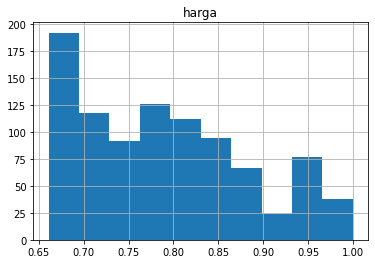

In [10]:
_ = oil_df.hist()

In [11]:
#Get the price and time step from dataframe
temp = oil_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [12]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

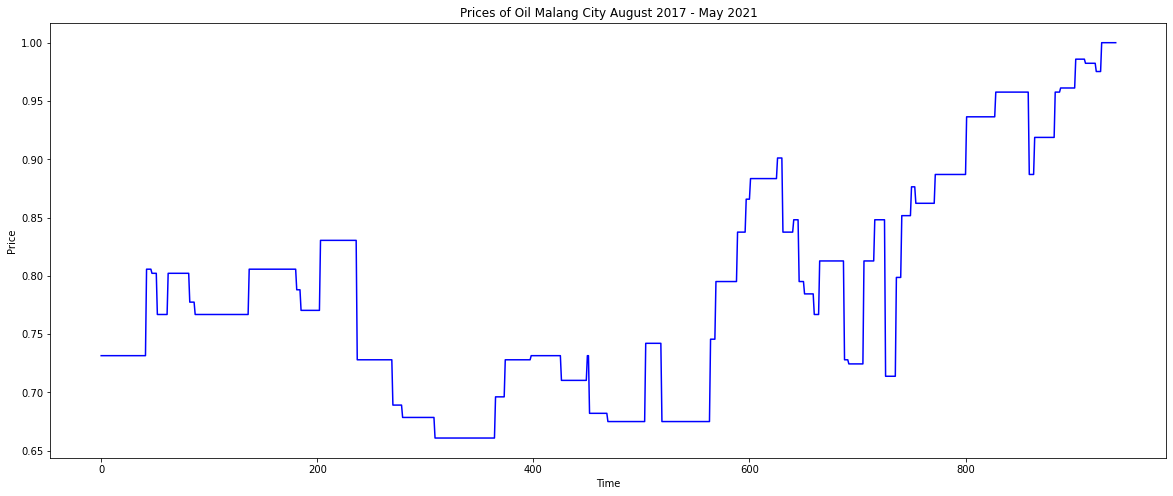

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Oil Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

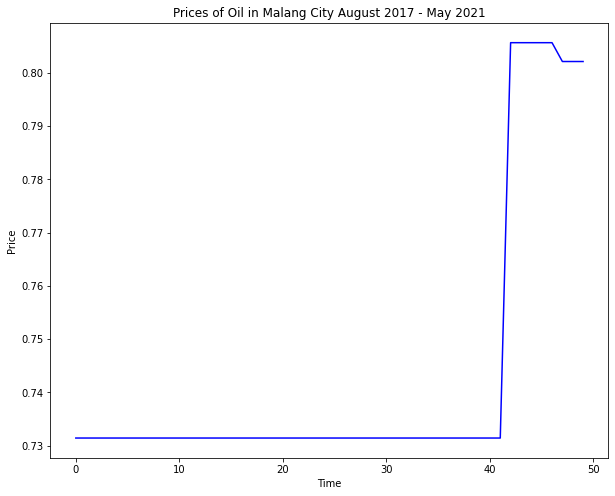

In [14]:
plt.figure(figsize=(10, 8))
plot_dataset(time=time[:50], series=price[:50], color='b', title='Prices of Oil in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [15]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [16]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [17]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [18]:
window_size = 40
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [20]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 91ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 4/200
2/2 [==============================] - 0s 13ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 5/200
2/2 [==============================] - 0s 14ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 6/200
2/2 [==============================] - 0s 14ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 7/200
2/2 [==============================] - 0s 18ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 0.3714 - mean_absolute_error: 0.8560
Epoch 9/200
2/2 [=========

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(0.0001, 0.1, 0.0, 0.2)

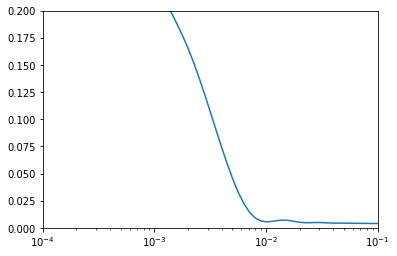

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.2])

In [19]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=500, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/500
2/2 [==============================] - 35s 836ms/step - loss: 0.2217 - mean_absolute_error: 0.6479 - val_loss: 0.0120 - val_mean_absolute_error: 0.1094
Epoch 2/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0328 - mean_absolute_error: 0.2013 - val_loss: 0.1146 - val_mean_absolute_error: 0.4529
Epoch 3/500
2/2 [==============================] - 0s 134ms/step - loss: 0.0891 - mean_absolute_error: 0.3927 - val_loss: 0.0092 - val_mean_absolute_error: 0.1160
Epoch 4/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0108 - mean_absolute_error: 0.1224 - val_loss: 0.0328 - val_mean_absolute_error: 0.2403
Epoch 5/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0366 - mean_absolute_error: 0.2553 - val_loss: 0.0321 - val_mean_absolute_error: 0.2374
Epoch 6/500
2/2 [==============================] - 0s 144ms/step - loss: 0.0247 - m

In [20]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


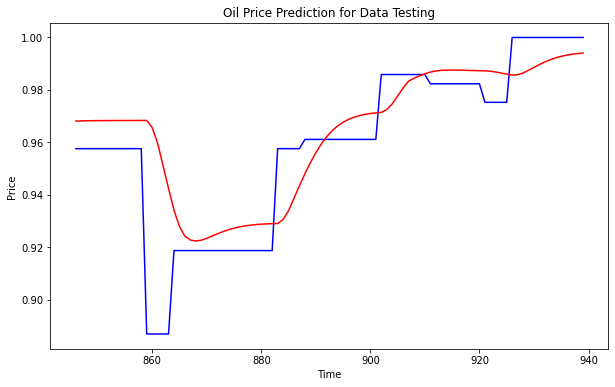

In [21]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Oil Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Oil Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

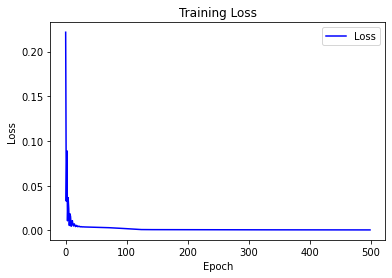

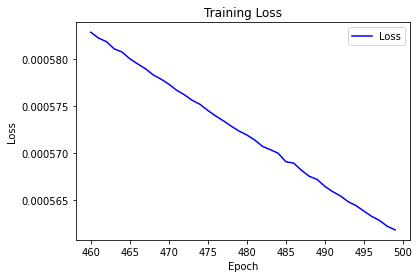

<Figure size 432x288 with 0 Axes>

In [23]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[460:]
epoch_num_zoom = [x+460 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [24]:
rnn_forecast

array([0.96811944, 0.96818334, 0.96822846, 0.9682603 , 0.96828306,
       0.9682995 , 0.96831155, 0.9683207 , 0.9683278 , 0.9683336 ,
       0.96833825, 0.96834224, 0.96834564, 0.9683486 , 0.96564245,
       0.95964164, 0.951065  , 0.942438  , 0.9341408 , 0.9279019 ,
       0.9242051 , 0.9227657 , 0.92236054, 0.9226912 , 0.92340684,
       0.9242753 , 0.92515606, 0.9259705 , 0.9266807 , 0.9272742 ,
       0.9277542 , 0.9281316 , 0.9284211 , 0.92863804, 0.92879707,
       0.92891103, 0.92899084, 0.9290453 , 0.9305813 , 0.9339288 ,
       0.9386844 , 0.94344944, 0.94800925, 0.95223486, 0.95604396,
       0.9593834 , 0.9621658 , 0.9644377 , 0.9662503 , 0.96766865,
       0.96875995, 0.96958685, 0.97020435, 0.97065985, 0.97099566,
       0.9712388 , 0.9714138 , 0.9724825 , 0.9746572 , 0.97768605,
       0.9807046 , 0.9833456 , 0.9844531 , 0.9853946 , 0.98616934,
       0.9867897 , 0.9872136 , 0.9874544 , 0.9875483 , 0.98757327,
       0.9875479 , 0.98749757, 0.98743844, 0.9873794 , 0.98732

In [25]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [26]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.7899412512779236],
  [0.7976750135421753],
  [0.8261944055557251],
  [0.8526110649108887],
  [0.8797696232795715],
  [0.9040382504463196],
  [0.9239887595176697],
  [0.9404091835021973],
  [0.9540066719055176],
  [0.9652383327484131],
  [0.9739865660667419],
  [0.9807787537574768],
  [0.9859907627105713],
  [0.988522469997406],
  [0.9893836379051208],
  [0.9900262355804443],
  [0.9905235767364502],
  [0.9909279346466064],
  [0.9912748336791992],
  [0.9915866851806641]]]

In [27]:
round(rnn_forecast[-1][-1][0]*max)

14031

In [28]:
model.save("oil_model")

INFO:tensorflow:Assets written to: oil_model/assets


INFO:tensorflow:Assets written to: oil_model/assets


In [29]:
!zip -r oil_model.zip oil_model

  adding: oil_model/ (stored 0%)
  adding: oil_model/assets/ (stored 0%)
  adding: oil_model/keras_metadata.pb (deflated 91%)
  adding: oil_model/saved_model.pb (deflated 89%)
  adding: oil_model/variables/ (stored 0%)
  adding: oil_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: oil_model/variables/variables.index (deflated 66%)
